In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer, enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

df.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,184966.93
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,300009.45
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,175616.23
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,2078.00,2,4,B,150226.53


In [4]:
df.shape

(10000, 19)

In [5]:
X_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,nan,0,0,B
15856,74,2.00,69.26,nan,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,4702.00,5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,nan,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A


In [6]:
X_test.shape

(5000, 18)

## Анализ некорректных данных

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.00,50.40,43.59,0.00,20.00,36.00,75.00,209.00
Rooms,10000.00,1.89,0.84,0.00,1.00,2.00,2.00,19.00
Square,10000.00,56.32,21.06,1.14,41.77,52.51,65.90,641.07
LifeSquare,7887.00,37.20,86.24,0.37,22.77,32.78,45.13,7480.59
KitchenSquare,10000.00,6.27,28.56,0.00,1.00,6.00,9.00,2014.00
Floor,10000.00,8.53,5.24,1.00,4.00,7.00,12.00,42.00
HouseFloor,10000.00,12.61,6.78,0.00,9.00,13.00,17.00,117.00
HouseYear,10000.00,3990.17,200500.26,1910.00,1974.00,1977.00,2001.00,20052011.00
Ecology_1,10000.00,0.12,0.12,0.00,0.02,0.08,0.20,0.52
Social_1,10000.00,24.69,17.53,0.00,6.00,25.00,36.00,74.00


In [8]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.00,51.28,44.18,0.00,21.00,37.00,77.00,212.00
Rooms,5000.00,1.91,0.84,0.00,1.00,2.00,2.00,17.00
Square,5000.00,56.45,19.09,1.38,41.91,52.92,66.29,223.45
LifeSquare,3959.00,36.16,17.83,0.33,23.09,32.93,45.17,303.07
KitchenSquare,5000.00,5.98,9.95,0.00,1.00,6.00,9.00,620.00
Floor,5000.00,8.63,5.48,1.00,4.00,7.00,12.00,78.00
HouseFloor,5000.00,12.60,6.79,0.00,9.00,12.00,17.00,99.00
HouseYear,5000.00,1984.39,18.57,1908.00,1973.00,1977.00,2000.00,2020.00
Ecology_1,5000.00,0.12,0.12,0.00,0.02,0.07,0.20,0.52
Social_1,5000.00,24.93,17.53,0.00,6.00,25.00,36.00,74.00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

### Район

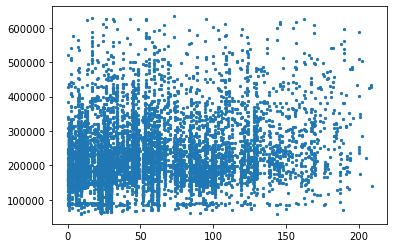

In [11]:
plt.scatter(df.DistrictId, df.Price, s=5)
plt.show()

In [12]:
df.DistrictId.value_counts(ascending=True).unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  31,  32,  33,  34,  35,  36,  37,  40,  41,  42,
        43,  44,  46,  48,  49,  51,  55,  56,  57,  58,  59,  61,  62,
        64,  65,  66,  67,  71,  72,  73,  76,  77,  78,  79,  80,  82,
        87,  89,  90,  92,  97, 104, 107, 111, 114, 116, 118, 119, 129,
       142, 143, 165, 174, 179, 228, 247, 294, 511, 565, 652, 851],
      dtype=int64)

In [13]:
df.DistrictId.value_counts(ascending=True).unique().shape[0]

90

In [14]:
X_test.DistrictId.value_counts(ascending=True).unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,  27,
        28,  29,  30,  31,  33,  34,  36,  38,  40,  41,  42,  43,  44,
        45,  46,  47,  49,  51,  54,  56,  60,  61,  64,  67,  70,  91,
       115, 122, 132, 257, 264, 344, 391], dtype=int64)

In [15]:
X_test.DistrictId.value_counts(ascending=True).unique().shape[0]

59

### Количество комнат

In [16]:
df.groupby('Rooms').agg({'Square': 'median', 'Rooms': 'count', 'Price':'median'})

,Square,Rooms,Price
Rooms,,,
0.00,65.49,8,214937.07
1.00,40.41,3705,154979.50
2.00,55.84,3880,200320.75
3.00,77.41,2235,268723.16
4.00,98.67,150,377524.23
5.00,116.08,18,455355.64
6.00,59.41,1,229661.96
10.00,59.96,2,244797.30
19.00,42.01,1,78364.62


Выбросы по количеству комнат скорректируем по площади и цене

In [17]:
df.loc[df.Rooms == 0, 'Rooms'] = 2
df.loc[df.Rooms == 10, 'Rooms'] = 2
df.loc[df.Rooms == 19, 'Rooms'] = 1
df.loc[df.Rooms == 6, 'Rooms'] = 2

In [18]:
df.groupby('Rooms').agg({'Square': 'median', 'Rooms': 'count', 'Price':'median'})

,Square,Rooms,Price
Rooms,,,
1.00,40.41,3706,154967.66
2.00,55.85,3891,200377.73
3.00,77.41,2235,268723.16
4.00,98.67,150,377524.23
5.00,116.08,18,455355.64


In [19]:
X_test.groupby('Rooms').agg({'Square': 'median', 'Rooms': 'count'})

,Square,Rooms
Rooms,,
0.00,96.58,2
1.00,40.12,1769
2.00,55.83,2030
3.00,77.68,1099
4.00,95.14,90
5.00,120.33,7
6.00,167.10,2
17.00,52.87,1


In [20]:
X_test.loc[X_test.Rooms == 0, 'Rooms'] = 4
X_test.loc[X_test.Rooms == 17, 'Rooms'] = 2

In [21]:
X_test.groupby('Rooms').agg({'Square': 'median', 'Rooms': 'count'})

,Square,Rooms
Rooms,,
1.00,40.12,1769
2.00,55.83,2031
3.00,77.68,1099
4.00,95.14,92
5.00,120.33,7
6.00,167.10,2


### Общая площадь

In [22]:
df.nlargest(5, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11602,30,2.00,641.07,638.16,10.00,20,19.00,2019,0.00,B,B,22,6398,141,1046.00,3,23,B,133529.68
28,9,2.00,604.71,nan,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,187717.24
2307,102,1.00,409.43,410.64,10.00,4,4.00,2016,0.24,B,B,26,3889,6,705.00,3,6,B,90470.43
5548,86,5.00,275.65,233.95,26.00,12,37.00,2011,0.16,B,A,31,7010,5,4508.00,3,7,B,455264.88
7917,27,2.00,212.93,211.23,0.00,2,3.00,2008,0.21,B,B,9,1892,0,nan,0,1,B,302211.26


In [23]:
df.nsmallest(15, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,B,B,1,264,0,nan,0,1,B,181434.83
15744,34,1.00,1.99,2.64,1.00,21,4.00,1977,0.07,B,B,53,13670,4,nan,1,11,B,458378.78
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B,126596.94
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,137597.60
6782,45,1.00,2.95,5.26,1.00,3,1.00,1977,0.20,B,B,23,5212,6,nan,3,2,B,438005.18
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,B,B,9,1892,0,nan,0,1,B,97560.72
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,B,B,9,1892,0,nan,0,1,B,161379.07
7657,38,1.00,4.50,4.62,1.00,28,1.00,1977,0.06,B,B,15,2787,2,520.00,0,7,B,483283.49
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,B,B,4,915,0,nan,0,0,B,107604.27


In [24]:
df.groupby('Rooms').agg({'Square': 'median', 'Price': 'median'})

,Square,Price
Rooms,,
1.00,40.41,154967.66
2.00,55.85,200377.73
3.00,77.41,268723.16
4.00,98.67,377524.23
5.00,116.08,455355.64


In [25]:
aggr = df.groupby('Rooms').agg({'Square': 'median', 'Price': 'mean'})
aggr.columns=['Square', 'Price_mean']
aggr

,Square,Price_mean
Rooms,,
1.00,40.41,159828.81
2.00,55.85,215244.72
3.00,77.41,289337.96
4.00,98.67,383251.10
5.00,116.08,410431.61


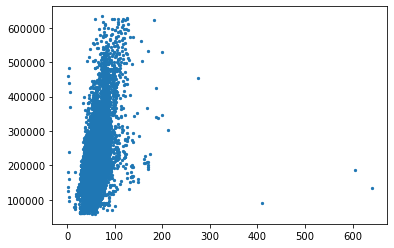

In [26]:
plt.scatter(df.Square, df.Price, s=5)
plt.show()

In [27]:
df.loc[(df.Square > 300) | (df.Square < 10)].sort_values('Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,B,B,1,264,0,nan,0,1,B,181434.83
15744,34,1.00,1.99,2.64,1.00,21,4.00,1977,0.07,B,B,53,13670,4,nan,1,11,B,458378.78
3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B,126596.94
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,137597.60
6782,45,1.00,2.95,5.26,1.00,3,1.00,1977,0.20,B,B,23,5212,6,nan,3,2,B,438005.18
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,B,B,9,1892,0,nan,0,1,B,97560.72
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,B,B,9,1892,0,nan,0,1,B,161379.07
7657,38,1.00,4.50,4.62,1.00,28,1.00,1977,0.06,B,B,15,2787,2,520.00,0,7,B,483283.49
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,B,B,4,915,0,nan,0,0,B,107604.27


Квартиры свыше 400 м<sup>2</sup>, судя по цене, относятся к категории 1-2 комнатных квартир площадью 40-55 м<sup>2</sup>, у квартир менее 10м<sup>2</sup> можно выделить две категории с границей по цене в 200 000

In [28]:
df.loc[df.index == 28, 'Square'] /= 10
df.loc[df.Square > 300, 'Square'] /= 15

In [29]:
df.loc[(df.Square < 10) & (df.Price > 200000), 'Square'] *= 20
df.loc[(df.Square < 10) & (df.Price < 200000), 'Square'] *= 10

#### Тестовые данные

In [30]:
X_test.nlargest(5, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4058,27,6.00,223.45,104.11,16.00,2,2.00,2017,0.04,B,B,53,14892,4,nan,1,4,B
1397,76,3.00,221.14,118.06,4.00,32,48.00,2011,0.00,B,B,7,1660,39,1786.00,1,5,B
7769,124,4.00,189.68,114.71,4.00,19,40.00,2013,0.17,B,B,17,3379,9,100.00,0,3,B
13589,27,3.00,173.97,76.29,9.00,3,3.00,2017,0.04,B,B,53,14892,4,nan,1,4,B
3357,27,3.00,170.48,75.97,8.00,2,2.00,2017,0.04,B,B,53,14892,4,nan,1,4,B


In [31]:
X_test.nsmallest(10, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
9011,53,1.00,1.38,1.35,1.00,1,1.00,1977,0.05,B,B,34,7759,0,229.00,1,3,B
1420,45,1.00,1.98,2.90,1.00,1,1.00,1977,0.20,B,B,23,5212,6,nan,3,2,B
1165,27,1.00,2.37,1.90,1.00,2,17.00,1977,0.01,B,B,4,915,0,nan,0,0,B
16401,30,1.00,2.65,4.34,1.00,2,1.00,1977,0.00,B,B,22,6398,141,1046.00,3,23,B
170,6,2.00,2.90,61.47,1.00,18,17.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B
7855,6,1.00,4.97,2.97,1.00,3,1.00,2018,0.24,B,B,5,1564,0,540.00,0,0,B
10120,6,1.00,5.10,3.86,1.00,3,1.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B
2138,27,1.00,5.65,1.50,1.00,1,1.00,1977,0.02,B,B,2,469,0,nan,0,0,B
15435,21,1.00,13.31,9.50,0.00,6,5.00,1965,0.19,B,B,47,8004,3,125.00,3,5,B


In [32]:
X_test.loc[X_test.index == 170, 'Square'] *= 25
X_test.loc[X_test.Square < 10, 'Square'] *= 10

### Площадь кухни

Случаи, когда общая площадь меньше площади кухни, а сама площадь кухни слишком мала или неадкватно велика

In [33]:
df.loc[df.Square < df.KitchenSquare]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.00,47.10,46.45,2014.00,4,1.00,2014,0.07,B,B,2,629,1,nan,0,0,A,108337.48
13703,42,1.00,38.07,19.72,73.00,9,10.00,2006,0.16,B,B,21,5731,0,nan,1,0,B,160488.03
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,B,B,4,915,0,nan,0,0,B,99079.96
14679,81,1.00,32.28,19.28,1970.00,6,1.00,1977,0.01,B,B,30,5285,0,645.00,6,6,B,105539.56


In [34]:
df.groupby('Rooms').agg({'Square': 'median', 'KitchenSquare':'median', 'Price': 'median'})

,Square,KitchenSquare,Price
Rooms,,,
1.00,40.42,6.00,154967.66
2.00,55.85,6.00,200377.73
3.00,77.42,7.00,268723.16
4.00,98.67,9.00,377524.23
5.00,116.08,9.00,455355.64


In [35]:
df.loc[df.KitchenSquare < 5].sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91
3774,58,2.00,86.41,84.75,0.00,7,0.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,165105.40
8616,27,2.00,63.76,34.46,0.00,14,17.00,1977,0.02,B,B,2,469,0,nan,0,0,B,172798.07
13146,74,1.00,46.45,nan,0.00,6,0.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,168705.45
15416,27,2.00,57.92,nan,0.00,14,19.00,1977,0.21,B,B,9,1892,0,nan,0,1,B,130755.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8906,84,1.00,35.99,23.68,4.00,6,5.00,1960,0.01,B,B,30,5285,0,645.00,6,6,B,158302.14
10541,101,2.00,43.60,33.84,4.00,2,5.00,1963,0.23,A,B,41,6558,7,1548.00,3,2,B,180026.27
11030,114,1.00,28.57,17.77,4.00,7,12.00,1966,0.33,B,B,12,2270,23,2500.00,1,0,B,181919.91


In [36]:
df.loc[df.KitchenSquare > 50].sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
673,27,1.00,54.42,51.50,51.00,10,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A,133273.64
12918,23,2.00,51.44,53.13,51.00,3,17.00,2017,0.01,B,B,1,388,0,nan,0,0,B,88150.01
4265,161,2.00,53.22,32.64,53.00,7,17.00,1994,0.00,B,B,14,3369,24,4129.00,0,3,B,261125.67
7162,34,2.00,56.74,57.51,54.00,26,25.00,2016,0.07,B,B,53,13670,4,nan,1,11,B,244220.62
12666,34,2.00,60.60,2.40,58.00,14,22.00,1977,0.07,B,B,53,13670,4,nan,1,11,B,261733.47
11739,27,2.00,61.07,59.85,58.00,8,17.00,2016,0.07,B,B,2,629,1,nan,0,0,A,212188.96
299,27,2.00,66.79,64.62,60.00,14,20.00,2015,0.02,B,B,2,469,0,nan,0,0,B,179466.09
16593,52,2.00,64.86,nan,62.00,15,17.00,1977,0.37,B,B,34,7065,1,750.00,2,5,B,185993.47
6508,23,2.00,67.15,33.96,63.00,5,17.00,2019,0.03,B,B,0,168,0,nan,0,0,B,193130.59


In [37]:
def kitchen_square(df):
    df.loc[(df.Square < df.KitchenSquare) | (df.KitchenSquare < 5) | 
           (df.KitchenSquare > 50), 'KitchenSquare'] = np.nan

In [38]:
kitchen_square(df)

#### Тестовые данные

In [39]:
X_test.loc[X_test.Square < X_test.KitchenSquare]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14594,11,2.00,42.80,24.22,620.00,11,14.00,1972,0.04,B,B,28,6533,1,1015.00,2,5,B
10662,29,1.00,25.96,17.25,33.00,5,5.00,1973,0.07,B,B,31,6119,4,nan,1,2,B
3194,29,2.00,43.93,31.03,44.00,6,5.00,1964,0.09,B,B,10,2277,2,1547.00,0,0,B
12640,6,2.00,54.63,31.49,97.00,4,17.00,2015,0.24,B,B,5,1564,0,540.00,0,0,B


In [40]:
X_test.groupby('Rooms').agg({'Square': 'median', 'KitchenSquare':'median'})

,Square,KitchenSquare
Rooms,,
1.00,40.17,6.00
2.00,55.83,6.00
3.00,77.68,7.00
4.00,95.14,8.00
5.00,120.33,8.00
6.00,167.10,8.00


In [41]:
X_test.loc[X_test.KitchenSquare < 5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
15856,74,2.00,69.26,nan,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A
7633,53,1.00,40.68,nan,1.00,21,21.00,1977,0.05,B,B,34,7759,0,229.00,1,3,B
13329,23,2.00,68.10,64.84,1.00,2,17.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
3310,6,3.00,84.63,nan,1.00,6,17.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12920,23,1.00,39.61,38.19,1.00,6,18.00,2013,0.03,B,B,0,168,0,nan,0,0,B
11732,1,1.00,46.60,nan,1.00,17,24.00,1977,0.01,B,B,1,264,0,nan,0,1,B
5361,53,3.00,80.10,nan,1.00,13,22.00,1977,0.05,B,B,34,7759,0,229.00,1,3,B


In [42]:
X_test.loc[X_test.KitchenSquare > 50].sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5199,27,2.00,59.05,61.65,57.00,13,12.00,2016,0.21,B,B,9,1892,0,nan,0,1,B
12612,27,2.00,60.99,33.65,60.00,5,17.00,2013,0.07,B,B,2,629,1,nan,0,0,A
5428,27,2.00,62.33,nan,61.00,12,17.00,1977,0.07,B,B,2,629,1,nan,0,0,A
8015,27,1.00,66.10,33.64,62.00,3,7.00,2016,0.01,B,B,1,290,0,nan,0,0,B
5260,73,3.00,69.36,51.25,65.00,6,6.00,1931,0.04,B,B,37,6856,84,1940.00,2,5,B
12640,6,2.00,54.63,31.49,97.00,4,17.00,2015,0.24,B,B,5,1564,0,540.00,0,0,B
3341,62,3.00,112.11,112.25,112.00,3,3.00,2017,0.07,B,B,2,629,1,nan,0,0,A
14594,11,2.00,42.80,24.22,620.00,11,14.00,1972,0.04,B,B,28,6533,1,1015.00,2,5,B


In [43]:
kitchen_square(X_test)

### Жилая площадь

Количество нулевых значений жилой площади

In [44]:
df[df.LifeSquare.isnull()].shape[0]

2113

In [45]:
X_test[X_test.LifeSquare.isnull()].shape[0]

1041

Случаи, когда общая площадь меньше жилой площади

In [46]:
df.loc[df.Square < df.LifeSquare]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8054,23,1.00,42.53,43.97,nan,3,9.00,2014,0.03,B,B,0,168,0,nan,0,0,B,95338.20
10521,38,3.00,104.21,106.34,nan,20,0.00,2017,0.06,B,B,15,2787,2,520.00,0,7,B,435462.05
2301,1,2.00,61.40,65.22,nan,17,22.00,2016,0.01,B,B,1,264,0,nan,0,1,B,199215.45
8753,25,3.00,85.95,89.80,nan,4,3.00,2017,0.07,B,B,53,13670,4,nan,1,11,B,309688.59
9870,62,1.00,51.83,53.49,nan,5,1.00,2015,0.07,B,B,2,629,1,nan,0,0,A,131797.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,30,2.00,59.02,59.44,12.00,5,5.00,2016,0.00,B,B,22,6398,141,1046.00,3,23,B,126281.14
12918,23,2.00,51.44,53.13,nan,3,17.00,2017,0.01,B,B,1,388,0,nan,0,0,B,88150.01
2737,27,3.00,123.43,125.81,nan,5,10.00,2015,0.02,B,B,2,469,0,nan,0,0,B,234194.84


In [47]:
def life_square(df):
    df.loc[df.Square < df.LifeSquare, 'LifeSquare'] = np.nan

In [48]:
life_square(df)

In [49]:
df.groupby('Rooms').agg({'Square': 'median', 'KitchenSquare':'median', 'LifeSquare':'median', 'Price': 'median'})

,Square,KitchenSquare,LifeSquare,Price
Rooms,,,,
1.00,40.42,8.00,21.41,154967.66
2.00,55.85,8.00,32.30,200377.73
3.00,77.42,9.00,46.68,268723.16
4.00,98.67,9.00,64.55,377524.23
5.00,116.08,9.50,80.46,455355.64


In [50]:
df.groupby('Rooms').agg({'Square': 'mean', 'KitchenSquare':'mean', 'LifeSquare':'mean', 'Price': 'mean'})

,Square,KitchenSquare,LifeSquare,Price
Rooms,,,,
1.00,41.33,8.07,23.39,159828.81
2.00,56.58,7.68,34.21,215244.72
3.00,76.96,8.62,48.84,289337.96
4.00,98.38,9.73,62.57,383251.10
5.00,122.61,11.71,89.45,410431.61


In [51]:
X_test.loc[X_test.Square < X_test.LifeSquare]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,4702.00,5,5,B
11160,58,1.00,48.61,48.75,nan,4,3.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B
6624,27,1.00,42.41,42.43,10.00,12,17.00,2017,0.01,B,B,4,915,0,nan,0,0,B
11513,1,1.00,37.48,40.59,nan,4,17.00,1977,0.01,B,B,1,264,0,nan,0,1,B
1872,30,2.00,52.45,52.80,nan,17,17.00,2016,0.00,B,B,22,6398,141,1046.00,3,23,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686,1,3.00,77.23,79.96,nan,18,17.00,1977,0.01,B,B,1,264,0,nan,0,1,B
3711,94,1.00,41.28,42.39,10.00,13,13.00,2014,0.28,B,B,33,8667,2,nan,0,6,B
5820,94,1.00,33.68,34.20,nan,10,9.00,1972,0.13,B,B,43,8429,3,nan,3,9,B


In [52]:
life_square(X_test)

In [53]:
X_test.groupby('Rooms').agg({'Square': 'median', 'KitchenSquare':'median', 'LifeSquare':'median'})

,Square,KitchenSquare,LifeSquare
Rooms,,,
1.00,40.17,8.00,21.51
2.00,55.83,7.00,32.42
3.00,77.68,8.00,46.86
4.00,95.14,9.00,62.93
5.00,120.33,11.00,69.56
6.00,167.10,16.00,104.11


### Этаж 

Несоответствие этажа квартиры и этажности дома

In [54]:
df.loc[(df.Floor > df.HouseFloor) & (df.HouseFloor >= 3)].sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
15808,23,3.00,68.81,68.72,nan,4,3.00,1977,0.01,B,B,1,388,0,nan,0,0,B,100480.95
5587,23,3.00,70.65,68.50,nan,4,3.00,1977,0.01,B,B,1,388,0,nan,0,0,B,108952.09
8158,74,3.00,134.23,nan,nan,4,3.00,1977,0.31,B,B,35,7715,4,990.00,0,6,B,181837.05
16766,58,1.00,49.29,nan,nan,5,3.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,122670.47
13914,23,3.00,74.22,44.99,13.00,5,3.00,2020,0.01,B,B,1,388,0,nan,0,0,B,106209.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,94,1.00,45.90,17.23,10.00,27,25.00,2016,0.28,B,B,33,8667,2,nan,0,6,B,91816.82
370,6,3.00,82.03,78.92,nan,27,25.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,211498.64
5976,6,3.00,103.30,nan,nan,26,25.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,271249.52


In [55]:
df.loc[(df.Floor > df.HouseFloor) & (df.HouseFloor < 3)].sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.00,80.31,nan,nan,14,0.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,221244.16
7388,34,4.00,95.99,nan,nan,4,0.00,1977,0.07,B,B,53,13670,4,nan,1,11,B,352426.84
6118,62,1.00,42.26,nan,nan,6,0.00,1977,0.07,B,B,2,629,1,nan,0,0,A,119183.60
572,46,3.00,75.50,nan,nan,7,0.00,1977,0.00,B,B,47,11319,0,1145.00,3,5,B,422792.12
3224,27,2.00,23.77,0.87,nan,1,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B,126596.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,93,3.00,137.29,nan,nan,3,2.00,1977,0.00,B,B,0,186,0,nan,0,0,B,197507.57
4213,74,1.00,37.06,nan,nan,4,2.00,1977,0.08,B,B,6,1437,3,nan,0,2,B,125991.12
9552,23,1.00,105.43,nan,nan,3,2.00,1977,0.01,B,B,2,475,0,nan,0,0,B,218718.05


In [56]:
X_test.loc[(X_test.Floor > X_test.HouseFloor) & (X_test.HouseFloor >= 3)].sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3993,27,2.00,63.94,29.62,14.00,4,3.00,2016,0.01,B,B,4,915,0,nan,0,0,B
1320,23,2.00,54.35,nan,nan,4,3.00,1977,0.01,B,B,1,388,0,nan,0,0,B
8165,62,3.00,139.10,nan,20.00,4,3.00,2015,0.07,B,B,2,629,1,nan,0,0,A
8744,85,2.00,73.73,nan,nan,4,3.00,1977,0.07,B,B,2,629,1,nan,0,0,A
12172,23,1.00,36.97,33.03,nan,4,3.00,1977,0.01,B,B,1,388,0,nan,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15358,13,1.00,43.23,22.08,9.00,27,25.00,2003,0.09,B,B,74,19083,2,nan,5,15,B
4606,19,1.00,46.73,19.46,9.00,26,25.00,2002,0.00,B,B,33,6783,3,nan,1,9,B
11509,23,1.00,41.84,nan,nan,26,25.00,1977,0.08,B,B,6,1437,3,nan,0,2,B


In [57]:
X_test.loc[(X_test.Floor > X_test.HouseFloor) & (X_test.HouseFloor < 3)].sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10729,27,4.00,76.35,42.82,12.00,14,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B
113,27,2.00,65.55,35.07,nan,17,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B
2873,6,3.00,77.94,nan,nan,12,0.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B
12512,27,1.00,40.95,nan,nan,2,0.00,1977,0.02,B,B,2,469,0,nan,0,0,B
3303,74,2.00,80.52,nan,nan,5,0.00,1977,0.31,B,B,35,7715,4,990.00,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15121,93,3.00,134.57,nan,nan,3,2.00,1977,0.00,B,B,0,186,0,nan,0,0,B
13169,23,2.00,58.56,nan,nan,3,2.00,2016,0.01,B,B,1,388,0,nan,0,0,B
6991,58,1.00,107.36,nan,nan,4,2.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B


In [58]:
def floor(df):
    df.loc[(df.Floor > df.HouseFloor) & (df.HouseFloor >= 3), 'Floor'] = df.HouseFloor
    df.loc[(df.Floor > df.HouseFloor) & (df.HouseFloor < 3), 'HouseFloor'] = df.Floor

In [59]:
floor(df)

In [60]:
floor(X_test)

In [61]:
df.sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
6903,23,1.00,36.37,nan,nan,1.00,1.00,1977,0.03,B,B,0,168,0,nan,0,0,B,88289.94
12183,23,2.00,54.36,nan,nan,1.00,1.00,1977,0.03,B,B,0,168,0,nan,0,0,B,91783.64
9487,5,1.00,102.58,5.55,nan,1.00,1.00,1977,0.15,B,B,16,3433,4,2643.00,4,5,B,369472.40
1638,27,2.00,95.53,94.89,12.00,1.00,1.00,1977,0.08,B,B,11,3097,0,nan,0,0,B,118454.78
10535,27,1.00,40.25,nan,nan,1.00,1.00,1977,0.01,B,B,4,915,0,nan,0,0,B,89068.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453,24,3.00,126.62,62.46,12.00,22.00,48.00,2011,0.11,B,B,50,12238,8,1970.00,2,3,B,179396.52
1674,76,2.00,74.34,41.04,5.00,42.00,48.00,2016,0.00,B,B,7,1660,39,1786.00,1,5,B,411691.50
10806,5,1.00,51.94,48.71,nan,6.00,99.00,1977,0.15,B,B,16,3433,4,2643.00,4,5,B,296127.12


In [62]:
df[df.Floor > 30]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11563,8,1.00,50.39,41.64,nan,32.00,32.00,2008,0.09,B,B,21,4346,2,165.00,1,2,B,97480.85
1674,76,2.00,74.34,41.04,5.00,42.00,48.00,2016,0.00,B,B,7,1660,39,1786.00,1,5,B,411691.50
3298,31,1.00,57.55,21.55,10.00,32.00,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,393799.53
6589,30,1.00,62.11,52.81,nan,31.00,44.00,2009,0.00,B,B,22,6398,141,1046.00,3,23,B,117647.46
8296,146,1.00,86.39,71.90,nan,37.00,38.00,2012,0.24,B,B,16,3893,27,nan,3,10,B,269113.58
8016,31,1.00,59.52,24.05,10.00,33.00,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,389554.06


In [63]:
df[df.HouseFloor > 30].shape[0]

28

In [64]:
X_test[X_test.HouseFloor > 30].shape[0]

23

In [65]:
def housefloor(df):
    df.loc[df.HouseFloor > 30, 'HouseFloor'] = df.Floor

In [66]:
housefloor(df)

In [67]:
housefloor(X_test)

### Год постройки

In [68]:
df.sort_values(by='HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13288,161,1.00,50.81,15.92,20.00,8.00,9.00,1910,0.01,B,B,19,3806,4,nan,0,3,B,287954.72
14556,183,4.00,151.15,98.19,23.00,6.00,7.00,1912,0.04,B,B,32,6748,93,562.00,4,10,B,284884.96
2085,161,1.00,63.29,29.39,18.00,3.00,9.00,1912,0.01,B,B,19,3806,4,nan,0,3,B,262279.81
6751,172,2.00,56.17,28.38,7.00,6.00,6.00,1914,0.00,B,B,7,1660,39,1786.00,1,5,B,423580.48
7920,183,3.00,102.96,48.32,14.00,4.00,6.00,1916,0.04,B,B,32,6748,93,562.00,4,10,B,284608.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14318,53,2.00,57.82,37.29,8.00,6.00,24.00,2020,0.05,B,B,34,7759,0,229.00,1,3,B,251249.37
8892,62,1.00,49.30,nan,9.00,9.00,12.00,2020,0.07,B,B,2,629,1,nan,0,0,A,151779.18
6731,120,2.00,85.09,77.98,10.00,7.00,10.00,2020,0.34,B,B,27,5664,48,2300.00,3,11,B,536020.26


In [69]:
df.loc[df.index == 10814, 'HouseYear'] = 2011
df.loc[df.index == 11607, 'HouseYear'] = 1968

In [70]:
X_test.sort_values(by='HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
12316,183,5.00,157.98,101.04,12.00,7.00,8.00,1908,0.25,B,B,14,2940,45,nan,3,6,B
5480,190,1.00,13.60,nan,12.00,2.00,5.00,1909,0.00,B,B,30,7538,87,4702.00,5,5,B
9076,60,3.00,61.40,38.59,8.00,5.00,5.00,1910,0.34,B,B,27,5664,48,2300.00,3,11,B
3726,161,1.00,52.71,20.50,11.00,3.00,7.00,1911,0.01,B,B,19,3806,4,nan,0,3,B
16217,206,4.00,76.43,50.34,11.00,6.00,6.00,1912,0.04,B,B,37,6856,84,1940.00,2,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4696,59,2.00,75.58,41.76,15.00,8.00,20.00,2020,0.02,B,B,37,7687,11,176.00,5,5,B
9398,58,2.00,71.00,nan,17.00,13.00,15.00,2020,0.44,B,B,23,5735,3,1084.00,0,5,B
8560,37,2.00,57.98,nan,10.00,7.00,20.00,2020,0.18,B,B,18,3594,4,192.00,1,5,B


### Экология

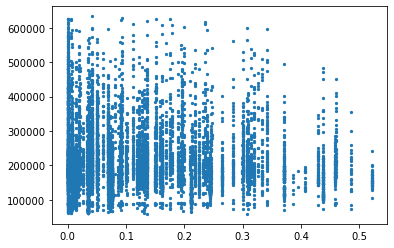

In [71]:
plt.scatter(df.Ecology_1, df.Price, s=5)
plt.show()

In [72]:
for i in ('df', 'X_test'):
    for j in (2, 3):
        k = f'{i}.Ecology_{j}.value_counts()'
        print(k, eval(k), '', sep='\n')

df.Ecology_2.value_counts()
B    9903
A      97
Name: Ecology_2, dtype: int64

df.Ecology_3.value_counts()
B    9725
A     275
Name: Ecology_3, dtype: int64

X_test.Ecology_2.value_counts()
B    4952
A      48
Name: Ecology_2, dtype: int64

X_test.Ecology_3.value_counts()
B    4851
A     149
Name: Ecology_3, dtype: int64



In [73]:
def ecology(df, col):
    df.loc[df[col] == 'A', col] = 0
    df.loc[df[col] == 'B', col] = 1
#     df[col] = df[col].astype(int)

In [74]:
for i in (df, X_test):
    for j in (2, 3):
        k = f'Ecology_{j}'
        ecology(i, k)

### Магазины

In [75]:
df.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [76]:
X_test.Shops_2.value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [77]:
def shops(df, col):
    df.loc[df[col] == 'A', col] = 0
    df.loc[df[col] == 'B', col] = 1
#     df[col] = df[col].astype(int)

In [78]:
shops(df, 'Shops_2')
shops(X_test, 'Shops_2')

### Здравоохранение

In [79]:
df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2586
KitchenSquare    3243
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [80]:
X_test.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1279
KitchenSquare    1572
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [81]:
df = df.rename(columns={'Helthcare_2': 'Healthcare_2'})
X_test = X_test.rename(columns={'Helthcare_2': 'Healthcare_2'})

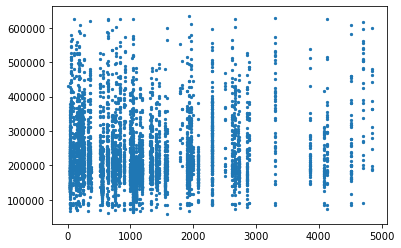

In [82]:
plt.scatter(df.Healthcare_1, df.Price, s=5)
plt.show()

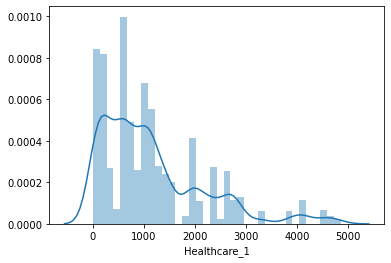

In [83]:
sns.distplot(df.Healthcare_1)
plt.show()

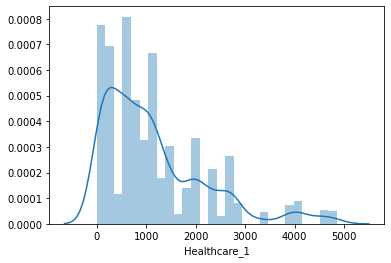

In [84]:
sns.distplot(X_test.Healthcare_1)
plt.show()

### Обработка пропусков

In [85]:
imputer = IterativeImputer(max_iter=100)

In [86]:
df_imp = pd.DataFrame(imputer.fit_transform(df))
df_imp.columns = df.columns
df_imp.index = df.index

In [87]:
df_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  float64
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  float64
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  float64
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  float64
 10  Ecology_3      10000 non-null  float64
 11  Social_1       10000 non-null  float64
 12  Social_2       10000 non-null  float64
 13  Social_3       10000 non-null  float64
 14  Healthcare_1   10000 non-null  float64
 15  Healthcare_2   10000 non-null  float64
 16  Shops_1        10000 non-null  float64
 17  Shops_2        10000 non-null  float64
 18  Pri

Не везде IterativeImputer сработал корректно, исправим вручную

In [88]:
df_imp.loc[(df_imp.Square < df_imp.KitchenSquare) | (df_imp.KitchenSquare < 3) | 
           (df_imp.KitchenSquare > 50)].sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
7594,53.00,5.00,39.91,39.39,-0.60,5.00,5.00,1977.00,0.05,1.00,1.00,34.00,7759.00,0.00,229.00,1.00,3.00,1.00,206148.85
6358,27.00,5.00,42.00,36.10,0.80,5.00,12.00,1977.00,0.01,1.00,1.00,4.00,915.00,0.00,824.89,0.00,0.00,1.00,112693.64


In [89]:
med_sq = np.median(df_imp.KitchenSquare / df_imp.Square)
med_sq

0.151909931600468

In [90]:
df_imp.loc[(df_imp.Square < df_imp.KitchenSquare) | (df_imp.KitchenSquare < 3) | 
           (df_imp.KitchenSquare > 50), 'KitchenSquare'] = df_imp.Square * med_sq

In [91]:
df_imp.loc[(df_imp.Square < df_imp.LifeSquare) | (df_imp.LifeSquare < 10)].sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
15466,88.00,1.00,42.36,-15.32,41.00,10.00,19.00,2016.00,0.13,1.00,1.00,43.00,8429.00,3.00,788.14,3.00,9.00,1.00,194525.10
16781,27.00,1.00,36.14,-10.60,36.00,19.00,19.00,2017.00,0.07,1.00,1.00,2.00,629.00,1.00,421.89,0.00,0.00,0.00,131742.54
13491,0.00,1.00,38.18,0.37,9.69,17.00,17.00,2016.00,0.01,1.00,1.00,30.00,5285.00,0.00,645.00,6.00,6.00,1.00,105134.29
4378,27.00,3.00,106.96,0.64,18.37,17.00,17.00,2018.00,0.07,1.00,1.00,2.00,629.00,1.00,560.64,0.00,0.00,0.00,337299.87
5112,6.00,2.00,63.59,0.80,10.00,17.00,17.00,2014.00,0.24,1.00,1.00,5.00,1564.00,0.00,540.00,0.00,0.00,1.00,174742.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9418,9.00,2.00,66.94,5.95,10.82,5.00,5.00,1977.00,0.16,1.00,1.00,25.00,5648.00,1.00,30.00,2.00,4.00,1.00,183976.84
14398,54.00,3.00,113.33,5.95,17.48,10.00,10.00,2014.00,0.01,1.00,1.00,30.00,5285.00,0.00,645.00,6.00,6.00,1.00,585031.27
16583,6.00,1.00,39.18,5.95,9.26,4.00,17.00,1977.00,0.24,1.00,1.00,5.00,1564.00,0.00,540.00,0.00,0.00,1.00,127997.03


In [92]:
med_sq_diff = np.median(df_imp.Square - df_imp.LifeSquare - df_imp.KitchenSquare)
med_sq_diff

11.495070867282365

In [93]:
df_imp.loc[(df_imp.Square < df_imp.LifeSquare) | (df_imp.LifeSquare < 10), 'LifeSquare'] = df_imp.Square - df_imp.KitchenSquare - med_sq_diff

In [94]:
df_imp.loc[(df_imp.Square < df_imp.LifeSquare) | (df_imp.LifeSquare < 5)].sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16781,27.00,1.00,36.14,-11.36,36.00,19.00,19.00,2017.00,0.07,1.00,1.00,2.00,629.00,1.00,421.89,0.00,0.00,0.00,131742.54
448,48.00,1.00,41.19,-11.31,41.00,2.00,2.00,1977.00,0.04,1.00,1.00,46.00,9515.00,5.00,907.66,1.00,10.00,1.00,216882.27
15466,88.00,1.00,42.36,-10.14,41.00,10.00,19.00,2016.00,0.13,1.00,1.00,43.00,8429.00,3.00,788.14,3.00,9.00,1.00,194525.10
12676,81.00,3.00,13.78,-4.71,7.00,4.00,5.00,1960.00,0.32,1.00,1.00,25.00,4756.00,16.00,2857.00,5.00,8.00,1.00,78388.81
14786,1.00,1.00,11.37,-4.04,3.91,3.00,3.00,1977.00,0.01,1.00,1.00,1.00,264.00,0.00,972.09,0.00,1.00,1.00,181434.83
15877,57.00,3.00,16.55,-2.95,8.00,5.00,5.00,1962.00,0.13,1.00,1.00,49.00,11395.00,3.00,1406.00,3.00,4.00,0.00,77835.19
15127,150.00,1.00,17.05,-2.45,8.00,7.00,12.00,1982.00,0.30,1.00,1.00,52.00,10311.00,6.00,1382.06,1.00,9.00,1.00,74222.11
6927,21.00,1.00,16.12,1.13,3.50,2.00,5.00,1965.00,0.19,1.00,1.00,47.00,8004.00,3.00,125.00,3.00,5.00,1.00,79913.27


In [95]:
df_imp.loc[df_imp.LifeSquare < -10, 'KitchenSquare'] = df_imp.Square * med_sq
df_imp.loc[df_imp.LifeSquare < -10, 'LifeSquare'] = df_imp.Square - df_imp.KitchenSquare - med_sq_diff

In [96]:
df_imp.loc[df_imp.LifeSquare < 0, 'LifeSquare'] = df_imp.Square - df_imp.KitchenSquare

### Обработка пропусков на тестовых данных

In [97]:
X_test_imp = pd.DataFrame(imputer.fit_transform(X_test))
X_test_imp.columns = X_test.columns
X_test_imp.index = X_test.index

In [98]:
X_test_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   float64
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   float64
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   float64
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   float64
 10  Ecology_3      5000 non-null   float64
 11  Social_1       5000 non-null   float64
 12  Social_2       5000 non-null   float64
 13  Social_3       5000 non-null   float64
 14  Healthcare_1   5000 non-null   float64
 15  Healthcare_2   5000 non-null   float64
 16  Shops_1        5000 non-null   float64
 17  Shops_2        5000 non-null   float64
dtypes: fl

In [99]:
X_test_imp.loc[(X_test_imp.Square < X_test_imp.LifeSquare) | (X_test_imp.LifeSquare < 9)].sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4483,62.00,1.00,41.95,-20.61,41.00,13.00,17.00,2018.00,0.07,1.00,1.00,2.00,629.00,1.00,588.44,0.00,0.00,0.00
5480,190.00,1.00,13.60,-6.01,12.00,2.00,5.00,1909.00,0.00,1.00,1.00,30.00,7538.00,87.00,4702.00,5.00,5.00,1.00
6553,34.00,5.00,122.38,0.33,14.14,9.00,9.00,1977.00,0.07,1.00,1.00,53.00,13670.00,4.00,1116.66,1.00,11.00,1.00
6406,27.00,2.00,66.47,0.57,11.99,4.00,4.00,2018.00,0.02,1.00,1.00,2.00,469.00,0.00,815.27,0.00,0.00,1.00
3028,9.00,1.00,43.35,0.81,10.49,16.00,17.00,2015.00,0.16,1.00,1.00,25.00,5648.00,1.00,30.00,2.00,4.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,72.00,1.00,101.53,5.77,19.84,25.00,25.00,2017.00,0.21,1.00,1.00,11.00,2398.00,2.00,1994.00,3.00,0.00,1.00
362,6.00,1.00,50.41,5.78,11.97,25.00,25.00,2018.00,0.24,1.00,1.00,5.00,1564.00,0.00,540.00,0.00,0.00,1.00
11228,6.00,1.00,79.09,5.80,14.27,3.00,3.00,1977.00,0.24,1.00,1.00,5.00,1564.00,0.00,540.00,0.00,0.00,1.00


In [100]:
X_test_imp.loc[(X_test_imp.Square < X_test_imp.LifeSquare) | (X_test_imp.LifeSquare < 9), 'LifeSquare'] = X_test_imp.Square - X_test_imp.KitchenSquare - med_sq_diff

In [101]:
X_test_imp.loc[(X_test_imp.Square < X_test_imp.LifeSquare) | (X_test_imp.LifeSquare < 5)].sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4483,62.00,1.00,41.95,-10.54,41.00,13.00,17.00,2018.00,0.07,1.00,1.00,2.00,629.00,1.00,588.44,0.00,0.00,0.00
5480,190.00,1.00,13.60,-9.90,12.00,2.00,5.00,1909.00,0.00,1.00,1.00,30.00,7538.00,87.00,4702.00,5.00,5.00,1.00
9011,53.00,1.00,13.79,-1.64,3.93,1.00,1.00,1977.00,0.05,1.00,1.00,34.00,7759.00,0.00,229.00,1.00,3.00,1.00
1420,45.00,1.00,19.76,3.42,4.84,1.00,1.00,1977.00,0.20,1.00,1.00,23.00,5212.00,6.00,1291.58,3.00,2.00,1.00


In [102]:
X_test_imp.loc[X_test_imp.LifeSquare < 0, 'KitchenSquare'] = X_test_imp.Square * med_sq
X_test_imp.loc[X_test_imp.LifeSquare < 0, 'LifeSquare'] = X_test_imp.Square - X_test_imp.KitchenSquare

In [103]:
df = df_imp
X_test = X_test_imp

## Распределение цен на недвижимость

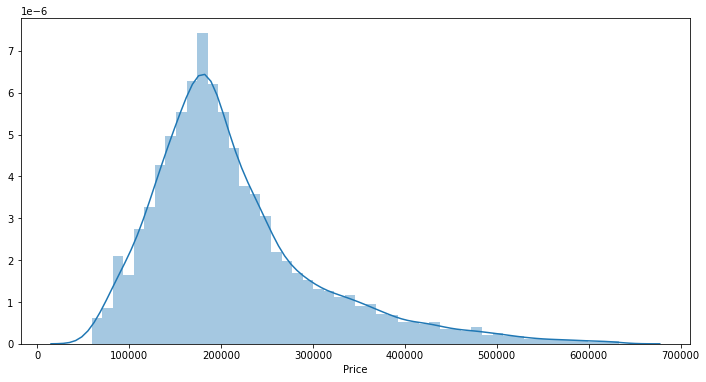

In [104]:
plt.figure(figsize=(12, 6))
sns.distplot(df.Price)
plt.show()

## Корреляционная матрица признаков

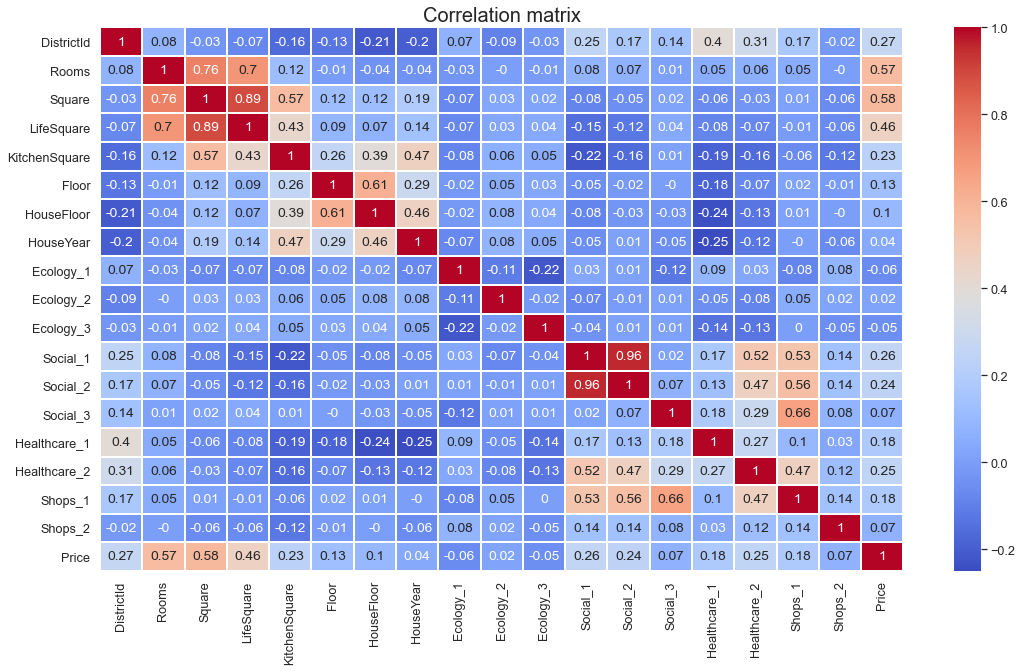

In [105]:
plt.figure(figsize = (18,10))
sns.set(font_scale=1.15)
sns.heatmap(df.corr().round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix', fontsize=20)
plt.show()

Признаки social_1 и social_2 сильно коррелированы

In [106]:
df = df.drop('Social_1', axis=1)

#### Тестовые данные

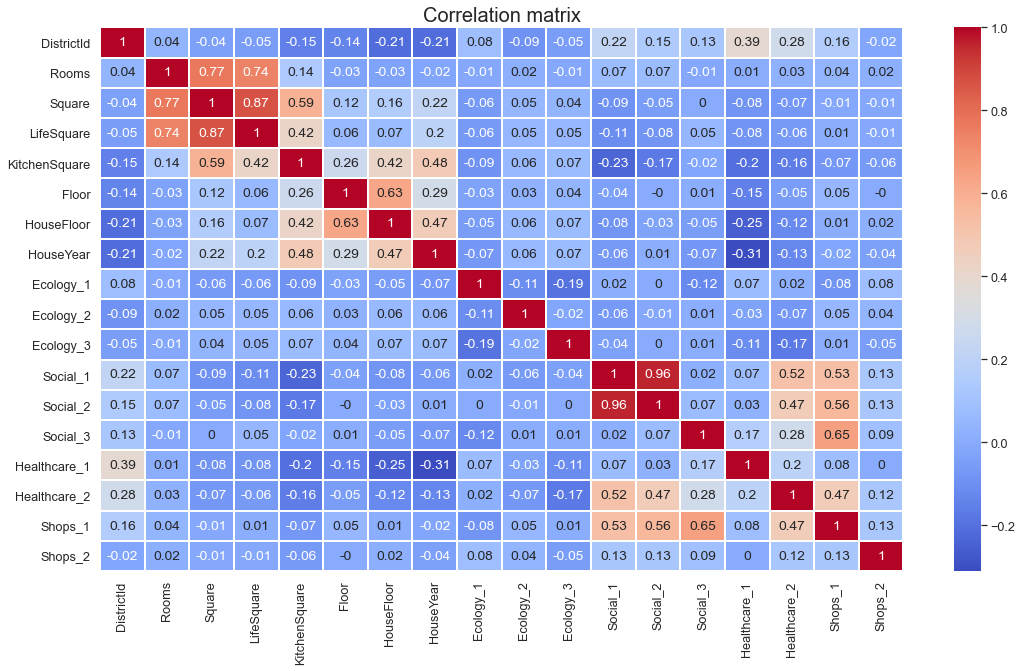

In [107]:
plt.figure(figsize = (18,10))
sns.set(font_scale=1.15)
sns.heatmap(X_test.corr().round(2), annot=True, linewidths=1, cmap='coolwarm')

plt.title('Correlation matrix', fontsize=20)
plt.show()

На тестовых данных признаки social_1 и social_2 также сильно коррелированы

In [108]:
X_test = X_test.drop('Social_1', axis=1)

## Построение новых признаков

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  float64
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  float64
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  float64
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  float64
 10  Ecology_3      10000 non-null  float64
 11  Social_2       10000 non-null  float64
 12  Social_3       10000 non-null  float64
 13  Healthcare_1   10000 non-null  float64
 14  Healthcare_2   10000 non-null  float64
 15  Shops_1        10000 non-null  float64
 16  Shops_2        10000 non-null  float64
 17  Price          10000 non-null  float64
dtypes: 

In [110]:
df.DistrictId = df.DistrictId.astype(int)
df.DistrictId = df.DistrictId.astype(str)

X_test.DistrictId = X_test.DistrictId.astype(int)
X_test.DistrictId = X_test.DistrictId.astype(str)

#### Cтоимость квадратного метра в зависимости от района

In [111]:
df['SqPrice'] = df['Price'] / df['Square']

In [112]:
sq_price_by_district = df.groupby('DistrictId', as_index=False).agg({'SqPrice':'median'}).rename(columns={'SqPrice':'SqPriceByDistrict'})

In [113]:
df_ = df.merge(sq_price_by_district, on='DistrictId', how='left')
df_.index = df.index
df = df_

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         10000 non-null  object 
 1   Rooms              10000 non-null  float64
 2   Square             10000 non-null  float64
 3   LifeSquare         10000 non-null  float64
 4   KitchenSquare      10000 non-null  float64
 5   Floor              10000 non-null  float64
 6   HouseFloor         10000 non-null  float64
 7   HouseYear          10000 non-null  float64
 8   Ecology_1          10000 non-null  float64
 9   Ecology_2          10000 non-null  float64
 10  Ecology_3          10000 non-null  float64
 11  Social_2           10000 non-null  float64
 12  Social_3           10000 non-null  float64
 13  Healthcare_1       10000 non-null  float64
 14  Healthcare_2       10000 non-null  float64
 15  Shops_1            10000 non-null  float64
 16  Shops_2            

In [115]:
X_test_ = X_test.merge(sq_price_by_district, on='DistrictId', how='left')
X_test_.index = X_test.index
X_test = X_test_

In [116]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         5000 non-null   object 
 1   Rooms              5000 non-null   float64
 2   Square             5000 non-null   float64
 3   LifeSquare         5000 non-null   float64
 4   KitchenSquare      5000 non-null   float64
 5   Floor              5000 non-null   float64
 6   HouseFloor         5000 non-null   float64
 7   HouseYear          5000 non-null   float64
 8   Ecology_1          5000 non-null   float64
 9   Ecology_2          5000 non-null   float64
 10  Ecology_3          5000 non-null   float64
 11  Social_2           5000 non-null   float64
 12  Social_3           5000 non-null   float64
 13  Healthcare_1       5000 non-null   float64
 14  Healthcare_2       5000 non-null   float64
 15  Shops_1            5000 non-null   float64
 16  Shops_2            50

In [117]:
X_test.SqPriceByDistrict.isnull().sum()

8

In [118]:
X_test.loc[X_test.SqPriceByDistrict.isnull(), 'SqPriceByDistrict'] = np.median(X_test.loc[X_test.SqPriceByDistrict.notnull(), 'SqPriceByDistrict'])

In [119]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         5000 non-null   object 
 1   Rooms              5000 non-null   float64
 2   Square             5000 non-null   float64
 3   LifeSquare         5000 non-null   float64
 4   KitchenSquare      5000 non-null   float64
 5   Floor              5000 non-null   float64
 6   HouseFloor         5000 non-null   float64
 7   HouseYear          5000 non-null   float64
 8   Ecology_1          5000 non-null   float64
 9   Ecology_2          5000 non-null   float64
 10  Ecology_3          5000 non-null   float64
 11  Social_2           5000 non-null   float64
 12  Social_3           5000 non-null   float64
 13  Healthcare_1       5000 non-null   float64
 14  Healthcare_2       5000 non-null   float64
 15  Shops_1            5000 non-null   float64
 16  Shops_2            50

In [120]:
X = df.drop(['Price', 'SqPrice'], axis=1)
y = df[['Price']]

In [121]:
X

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,SqPriceByDistrict
Id,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7.00,9.00,1969.00,0.09,1.00,1.00,7976.00,5.00,724.88,0.00,11.00,1.00,4358.27
15053,41,3.00,65.68,40.05,8.00,7.00,9.00,1978.00,0.00,1.00,1.00,10309.00,1.00,240.00,1.00,16.00,1.00,4437.30
4765,53,2.00,44.95,29.20,6.24,8.00,12.00,1968.00,0.05,1.00,1.00,7759.00,0.00,229.00,1.00,3.00,1.00,4845.92
5809,58,2.00,53.35,52.73,9.00,8.00,17.00,1977.00,0.44,1.00,1.00,5735.00,3.00,1084.00,0.00,5.00,1.00,2949.98
10783,99,1.00,39.65,23.78,7.00,11.00,12.00,1976.00,0.01,1.00,1.00,5776.00,1.00,2078.00,2.00,4.00,1.00,3992.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.00,50.40,30.48,5.00,5.00,5.00,1968.00,0.14,1.00,1.00,7960.00,6.00,350.00,3.00,11.00,1.00,5067.19
6159,18,1.00,41.52,20.54,9.00,13.00,13.00,2000.00,0.00,1.00,1.00,5562.00,0.00,582.31,0.00,5.00,0.00,4120.03
5123,27,1.00,47.94,28.60,10.80,12.00,16.00,2015.00,0.07,1.00,1.00,629.00,1.00,596.17,0.00,0.00,0.00,2759.20


In [122]:
y

,Price
Id,
14038,184966.93
15053,300009.45
4765,220925.91
5809,175616.23
10783,150226.53
...,...
77,196684.32
6159,189050.29
5123,159143.81


In [123]:
poly = PolynomialFeatures()

In [124]:
X_poly = pd.DataFrame(poly.fit_transform(X))
X_poly.index = X.index

In [125]:
X_test_poly = pd.DataFrame(poly.fit_transform(X_test))
X_test_poly.index = X_test.index

In [126]:
X_poly.shape

(10000, 190)

In [127]:
X_test_poly.shape

(5000, 190)

## Обучение модели

In [128]:
parameters = {
    'n_estimators': [100, 200, 300, 500, 700],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10],
    'max_features': [4, 7, 10],
    'max_depth': [5, 10, None]
}

In [129]:
rf_model = RandomForestRegressor(random_state=42)
et_model = ExtraTreesRegressor(random_state=42)

In [130]:
def gscv(model):
    gcv = GridSearchCV(estimator=model, param_grid=parameters, scoring='r2', cv=5, verbose=3, n_jobs=-1)
    gcv.fit(X, y.values[:, 0])
    print('Best estimator:', gcv.best_estimator_)
    print('Best parameters:', gcv.best_params_)
    print('Best score:', gcv.best_score_)

In [131]:
# gscv(rf_model)

In [132]:
# gscv(et_model)

In [135]:
rf_model = RandomForestRegressor(min_samples_leaf=1, min_samples_split=5, n_estimators=700, max_depth=None, 
                                 max_features=10, n_jobs=-1, verbose=1, random_state=42)
rf_model.fit(X, y.values[:, 0])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.7s finished


RandomForestRegressor(max_features=10, min_samples_split=5, n_estimators=700,
                      n_jobs=-1, random_state=42, verbose=1)

In [136]:
et_model = ExtraTreesRegressor(min_samples_leaf=1, min_samples_split=5, n_estimators=700, max_depth=None,
                               max_features=10, n_jobs=-1, verbose=1, random_state=42)
et_model.fit(X, y.values[:, 0])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    1.9s finished


ExtraTreesRegressor(max_features=10, min_samples_split=5, n_estimators=700,
                    n_jobs=-1, random_state=42, verbose=1)

In [137]:
vr_model = VotingRegressor([('RandomForest', rf_model), ('ExtraTrees', et_model)], verbose=1, n_jobs=-1)
vr_model.fit(X, y.values[:, 0])

VotingRegressor(estimators=[('RandomForest',
                             RandomForestRegressor(max_features=10,
                                                   min_samples_split=5,
                                                   n_estimators=700, n_jobs=-1,
                                                   random_state=42,
                                                   verbose=1)),
                            ('ExtraTrees',
                             ExtraTreesRegressor(max_features=10,
                                                 min_samples_split=5,
                                                 n_estimators=700, n_jobs=-1,
                                                 random_state=42, verbose=1))],
                n_jobs=-1, verbose=1)

## Перекрестная проверка и важность признаков

In [138]:
def score(model):
    cv_score = cross_val_score(model, X, y.values[:, 0], scoring='r2', verbose=1, n_jobs=-1,
                               cv=KFold(n_splits=10, shuffle=True, random_state=42))
    print(f'R2 score: {cv_score.mean():.4f} +- {cv_score.std():.4f}')

In [139]:
score(rf_model)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


R2 score: 0.7686 +- 0.0247


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.4s finished


In [140]:
score(et_model)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


R2 score: 0.7663 +- 0.0242


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.5s finished


In [141]:
score(vr_model)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


R2 score: 0.7705 +- 0.0245


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   52.0s finished


In [142]:
pd.DataFrame(
    zip(X.columns, rf_model.feature_importances_), 
    columns=['feature_name', 'importance_RandomForest']
).sort_values(by='importance_RandomForest', ascending=False)

,feature_name,importance_RandomForest
2,Square,0.32
17,SqPriceByDistrict,0.26
1,Rooms,0.10
3,LifeSquare,0.06
11,Social_2,0.05
4,KitchenSquare,0.03
7,HouseYear,0.03
13,Healthcare_1,0.02
12,Social_3,0.02
6,HouseFloor,0.02


In [143]:
pd.DataFrame(
    zip(X.columns, et_model.feature_importances_), 
    columns=['feature_name', 'importance_ExtraTrees']
).sort_values(by='importance_ExtraTrees', ascending=False)

,feature_name,importance_ExtraTrees
1,Rooms,0.21
17,SqPriceByDistrict,0.21
2,Square,0.17
3,LifeSquare,0.07
4,KitchenSquare,0.05
11,Social_2,0.04
7,HouseYear,0.03
0,DistrictId,0.03
14,Healthcare_2,0.03
6,HouseFloor,0.03


## Предсказание цен

In [144]:
preds_X = vr_model.predict(X)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 700 out of 700 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 700 out of 700 | elapsed:    0.1s finished


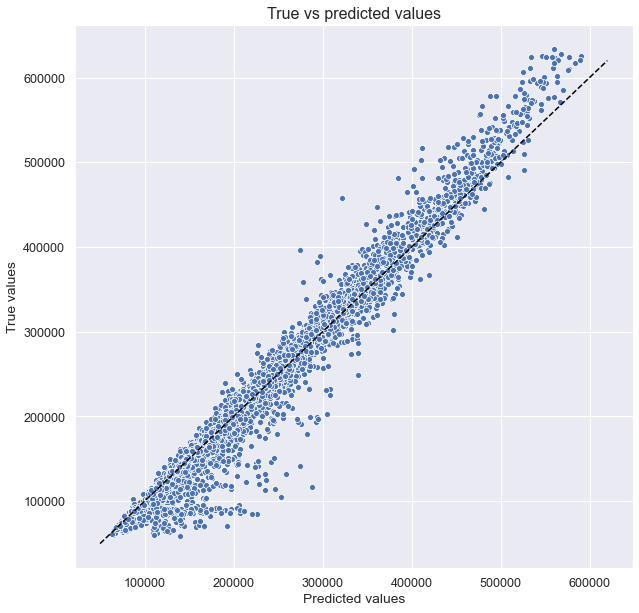

In [145]:
plt.figure(figsize=(10,10))
    
sns.scatterplot(x=preds_X, y=y.Price)
plt.plot([50000, 620000], [50000, 620000], linestyle='--', color='black')
    
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs predicted values', fontsize=16)
plt.show()

In [146]:
preds_X_test = vr_model.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 700 out of 700 | elapsed:    0.0s finished


In [147]:
result = pd.DataFrame()
result['Id'] = X_test.index
result['Price'] = preds_X_test
result.set_index('Id', inplace=True)

In [148]:
result.shape

(5000, 1)

In [149]:
result.to_csv('predictions.csv')